# Machine Learning - Rating Prediction


### The objective is to predict a new venue's popularity when the venue opens using a data set of venue popularities provided by Yelp. The data set contains information about the venue (where it is located, the type of food served, etc.). It also contains a star rating. The venues are not limited to restaurants. 

### Pre-processing the data

We start by downloading the data set from Amazon S3:

In [5]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In [7]:
star_ratings = [row['stars'] for row in data]

### Since venues belong to different cities, the ratings in some cities are likely higher than others.Therefore, I build an estimator to make a prediction based on this.

In [6]:
from collections import defaultdict

star_sum = defaultdict(int) 
count = defaultdict(int)

In [ ]:
cities = [row['city'] for row in data]

In [11]:
for row, stars in zip(cities, star_ratings):
    star_sum[row] += stars # increment the running sum in star_sum
    count[row] += 1 # increment the running count in count

In [76]:
avg_stars = dict()  # calculate average star rating and store in avg_stars

avg_scores = [star_sum[city]/ count[city] for city in star_sum]
cities = [city for city in star_sum]

for city, score in zip(cities, avg_scores):
    avg_stars[city] = score

In [80]:
cities = [avg_stars[city] for city in avg_stars]

### I build a custom estimator that will make a prediction based just on the city of a venue. If the city is not in the list I will impute the average of the sample.

In [67]:
from sklearn.base import BaseEstimator, RegressorMixin
from collections import defaultdict
import numpy as np

class CityRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.avg_stars = dict()
        
    
    def fit(self, X, y):
        y = [row['stars'] for row in X]
        city_list = [row['city'] for row in X]
        star_sum, count = defaultdict(int) 
        for row, stars in zip(city_list, y):
            star_sum[row] += stars 
            count[row] += 1 
        self.avg_scores = [star_sum[city] / count[city] for city in star_sum]
        cities = [city for city in star_sum]
        for city, score in zip(cities, self.avg_scores):
            self.avg_stars[city] = score # Store the average rating per city in self.avg_stars
        return self
        
    def predict(self, X):
        cities = [row['city'] for row in X]
        predicts = []
        for city in cities:
            if city in self.avg_stars:
                predicts.append(self.avg_stars[city])
            else:
                predicts.append(np.mean(self.avg_scores))
        return predicts

In [68]:
city_model = CityRegressor()


In [79]:
city_model.fit(data, star_ratings)

CityRegressor()

In [10]:
city_model.predict(data[:5]) # checking whether it's working

[3.6702903946388683, 3.75, 3.75, 3.75, 3.75]

There is a problem, however.  What happens if we're asked to estimate the rating of a venue in a city that's not in our training set?

In [157]:
city_model.predict([{'city': 'Phoenix'}, {'city': 'Timbuktu'}, {'city': 'Madison'}])

[3.6702903946388683, 3.712759336095809, 3.6457337883959045]

### The model above does not take into account neighborhoods that are trendy. I use the latitude and longitude of a venue to understand neighborhood dynamics.(KNeighbors Regression)

In [11]:
from sklearn.base import BaseEstimator
import pandas as pd
from sklearn.base import TransformerMixin

class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = pd.DataFrame(X)# Return a pandas data frame from X
        return df

In [12]:
import numpy as np
from sklearn.compose import ColumnTransformer

selector = ColumnTransformer([('lat_lon', 'passthrough', ['latitude', 'longitude'])]) 

expected = np.array([data[0]['latitude'], data[0]['longitude']])


In [20]:
from sklearn.neighbors import KNeighborsRegressor

# Training the model
data_transform = to_data_frame.transform(data)
data_transform = selector.fit_transform(data_transform)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)

# Making predictions
test_data = data[:5]
test_data_transform = to_data_frame.transform(test_data)
test_data_transform = selector.transform(test_data_transform) # did not fit here because it's the test data
knn.predict(test_data_transform)

array([4. , 4.2, 4. , 3.8, 4.2])

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle


lang_long_model = Pipeline([
    ('data_frame', to_data_frame),
    ('selector', selector),
    ('knn_regression', KNeighborsRegressor(n_neighbors = 5))
])

In [49]:
lang_long_model.fit(data, star_ratings)
lang_long_model.predict(data[:5])

array([4. , 4.2, 4. , 3.8, 4.2])

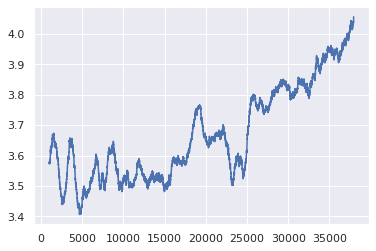

In [20]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean());

In [114]:
from sklearn.model_selection import GridSearchCV

X_random_order, y_random_order = shuffle(data_transform, star_ratings, random_state=42)


knn_model = KNeighborsRegressor()
gs = GridSearchCV(
    knn_model,
    {"n_neighbors": range(1,100)}, # range of hyperparameters to test  
     cv=10, # 10-fold cross validation
    n_jobs=2
)

gs.fit(X_random_order, y_random_order)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(), n_jobs=2,
             param_grid={'n_neighbors': range(1, 100)})

In [115]:
print("The best hyperparameter value is: ", gs.best_params_)


The best hyperparameter value is:  {'n_neighbors': 52}


In [52]:
gs.predict(data_transform[:15])

array([3.8 , 3.8 , 4.  , 4.  , 3.8 , 2.95, 3.75, 3.85, 3.45, 3.15, 3.85,
       3.45, 3.85, 3.45, 3.55])

In [ ]:
## Now that I know the neighbors are 52 I will rewrite the above. 

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle

lat_long_model = Pipeline([
    ('data_frame', to_data_frame),
    ('selector', selector),
    ('knn_regression', KNeighborsRegressor(n_neighbors = 52))
])


In [117]:
X_random_order2, y_random_order2 = shuffle(data, star_ratings, random_state=42)


In [ ]:
lat_long_model.fit(X_random_order2, y_random_order2)

In [119]:
lat_long_model.predict(data[:5])

array([3.94230769, 3.69230769, 3.69230769, 3.63461538, 3.68269231])

### Now I try to predict rating with venue's category building an estimator that considers only the `'categories'` section of data. (Ridge Regression)

In [1]:
import pandas as pd

In [3]:
X_in = pd.Series([['a'], ['b', 'c']])
X_out = pd.Series([{'a': 1}, {'b': 1, 'c': 1}])

print(X_in)
print(X_out)

0       [a]
1    [b, c]
dtype: object
0            {'a': 1}
1    {'b': 1, 'c': 1}
dtype: object


In [5]:
def convert(given):
    my_list = []
    for nested_list in given:
        count = [nested_list.count(letter) for letter in nested_list]
        dictionary = {nested_list[y]: count[y] for y in range(0, len(nested_list))}
        my_list.append(dictionary)
    return pd.Series(my_list)

In [8]:
convert(X_in)

0            {'a': 1}
1    {'b': 1, 'c': 1}
dtype: object

In [20]:
from sklearn.base import BaseEstimator
import pandas as pd
from sklearn.base import TransformerMixin

class DictEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        my_list = []
        categories = [row['categories'] for row in X]
        for nested_list in categories:
            count = [nested_list.count(letter) for letter in nested_list]
            dictionary = {nested_list[y]: count[y] for y in range(0, len(nested_list))}
            my_list.append(dictionary)
        return pd.Series(my_list) # X will be a pandas series. Return a pandas series of dictionaries     

In [21]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer()

In [23]:
dict_encoder = DictEncoder()
data_encoded = dict_encoder.fit_transform(data)

In [31]:
data_encoded

0                    {'Doctors': 1, 'Health & Medical': 1}
1                                       {'Restaurants': 1}
2          {'American (Traditional)': 1, 'Restaurants': 1}
3        {'Food': 1, 'Ice Cream & Frozen Yogurt': 1, 'F...
4                         {'Chinese': 1, 'Restaurants': 1}
                               ...                        
37933    {'Bars': 1, 'Hookah Bars': 1, 'Nightlife': 1, ...
37934    {'Active Life': 1, 'Barre Classes': 1, 'Pilate...
37935                {'Yelp Events': 1, 'Local Flavor': 1}
37936    {'Kosher': 1, 'Italian': 1, 'Pizza': 1, 'Resta...
37937    {'Food': 1, 'Ethnic Food': 1, 'Grocery': 1, 'S...
Length: 37938, dtype: object

In [32]:
vectorized = v.fit_transform(data_encoded); vectorized

<37938x706 sparse matrix of type '<class 'numpy.float64'>'
	with 108205 stored elements in Compressed Sparse Row format>

In [24]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline


category_model = Pipeline([
    ('dict_encoder', dict_encoder),
    ('vectorizer', v),
    ('ridge_reg', Ridge())
])

In [76]:
category_model.fit(data, star_ratings)

Pipeline(steps=[('dict_encoder', DictEncoder()),
                ('vectorizer', DictVectorizer()), ('ridge_reg', Ridge())])

In [39]:
category_model.predict(data[:5])

array([3.33938799, 3.34715743, 3.28317329, 3.22126968, 3.30403748])

In [80]:
from sklearn.model_selection import GridSearchCV

rg = Ridge()
ridge_model = GridSearchCV(
    rg,
    {'alpha': [1,2,3,4,5,6,7,8,9,10,12,15,20]}, # range of hyperparameters to test  
     cv=10 # 5-fold cross validation
)

ridge_model.fit(vectorized, star_ratings) 


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20]})

In [81]:
ridge_model.best_params_

{'alpha': 7}

### Next I use attributes for each venue to star rating. (Ridge Regression & Random Forest & Custom built Boosting logic - Linear+NonlinearModel)


In [25]:
# 1...to pd 
to_data_frame = ToDataFrame()
transformed_data = to_data_frame.fit_transform(data)

In [16]:
## Building custom transformer to flatten the dictionary

In [26]:
# to see whether function works outside transformer

def flatten(d, prefix=''):
    prefix = prefix + '_' if prefix else ''
    new = {}
    for k, v in d.items():
        if isinstance(v, bool):
            new[prefix + k] = int(v)
        elif isinstance(v, dict):
            new.update(flatten(v, prefix=prefix + k))
        elif isinstance(v, str):  
            new[prefix + k + '_' + v] = 1
    return new

transformed_data['attributes'].apply(flatten)


0                               {'By Appointment Only': 1}
1        {'Take-out': 1, 'Good For_dessert': 0, 'Good F...
2        {'Take-out': 1, 'Good For_dessert': 0, 'Good F...
3        {'Take-out': 1, 'Wi-Fi_free': 1, 'Takes Reserv...
4        {'Take-out': 1, 'Has TV': 0, 'Outdoor Seating'...
                               ...                        
37933    {'Alcohol_none': 1, 'Good For Dancing': 1, 'No...
37934                                                   {}
37935                                 {'Good for Kids': 0}
37936    {'Take-out': 1, 'Wi-Fi_no': 1, 'Good For_desse...
37937    {'Parking_garage': 0, 'Parking_street': 0, 'Pa...
Name: attributes, Length: 37938, dtype: object

In [10]:
atts = transformed_data['attributes']


In [27]:
from sklearn.base import BaseEstimator
import pandas as pd
from sklearn.base import TransformerMixin

class DictFlattener(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def flatten(d, prefix=''):
        prefix = prefix + '_' if prefix else ''
        new = {}
        for k, v in d.items():
            if isinstance(v, bool):
                new[prefix + k] = int(v)
            elif isinstance(v, dict):
                new.update(flatten(v, prefix=prefix + k))
            elif isinstance(v, str):  
                new[prefix + k + '_' + v] = 1
        return new
    
    def transform(self, X):
        attributes = X['attributes']
        return attributes.apply(flatten)

In [28]:
dict_flattener = DictFlattener()

my_dict = dict_flattener.fit_transform(transformed_data) # seems to be working fine

In [16]:
my_dict = pd.Series(my_dict); my_dict


0                               {'By Appointment Only': 1}
1        {'Take-out': 1, 'Good For_dessert': 0, 'Good F...
2        {'Take-out': 1, 'Good For_dessert': 0, 'Good F...
3        {'Take-out': 1, 'Wi-Fi_free': 1, 'Takes Reserv...
4        {'Take-out': 1, 'Has TV': 0, 'Outdoor Seating'...
                               ...                        
37933    {'Alcohol_none': 1, 'Good For Dancing': 1, 'No...
37934                                                   {}
37935                                 {'Good for Kids': 0}
37936    {'Take-out': 1, 'Wi-Fi_no': 1, 'Good For_desse...
37937    {'Parking_garage': 0, 'Parking_street': 0, 'Pa...
Name: attributes, Length: 37938, dtype: object

In [ ]:
# Vectorizing

In [29]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer()

In [18]:
vectorized = v.fit_transform(my_dict); vectorized

<37938x92 sparse matrix of type '<class 'numpy.float64'>'
	with 506304 stored elements in Compressed Sparse Row format>

#### RIDGE AND SELECTING ALPHA

In [19]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


rg = Ridge()
ridge = GridSearchCV(
    rg,
    {'alpha': [1,0.1,0.01,0.001,0.0001,0]}, # range of hyperparameters to test  
     n_jobs=-1
)

ridge.fit(vectorized, star_ratings) 

GridSearchCV(estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0]})

In [20]:
ridge.best_params_

{'alpha': 1}

In [21]:
ridge_predicts = ridge.predict(vectorized)

In [46]:
ridge.score(vectorized, star_ratings)

0.07129656382651806

#### Predicting Residuals

In [22]:
residuals = star_ratings - ridge_predicts

In [ ]:
RANDOM AND SELECTING PARAMATERS

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
random_forest = GridSearchCV(
    rf,
    {'max_depth':[20,50], 'min_samples_leaf':[15, 30]}
)



In [31]:
random_forest.fit(vectorized, residuals)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [20, 50], 'min_samples_leaf': [15, 30]})

In [32]:
random_forest.best_params_

{'max_depth': 20, 'min_samples_leaf': 15}

In [86]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(max_depth = 70, min_samples_leaf = 1, n_estimators = 50)

In [84]:

r_forest = random_forest.fit(vectorized, residuals)

In [85]:
r_forest.score(vectorized, residuals)

0.16631745624638972

In [87]:
# writing the class

In [48]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

class LinNonLin(BaseEstimator, RegressorMixin):
    
    def __init__(self, ridge = Ridge(alpha = 1), 
                 randomforest = RandomForestRegressor(max_depth = 30, min_samples_leaf = 12, n_estimators = 80)):
        self.ridge = ridge
        self.randomforest = randomforest

    def fit(self, X, y):
        self.ridge_reg = self.ridge.fit(X, y) 
        self.ridge_predicts = self.ridge_reg.predict(X)
        self.residuals = y - self.ridge_predicts
        self.random_forest = self.randomforest.fit(X, self.residuals)
        return self
        
    def predict(self, X):
        ridge_predicts = self.ridge_reg.predict(X)
        forest_predicts = self.random_forest.predict(X)
        total_predicts = ridge_predicts + forest_predicts
        return total_predicts

In [49]:
linnonlin = LinNonLin()

In [ ]:
model = linnonlin.fit(vectorized, star_ratings)

In [124]:
model.score(vectorized, star_ratings)

0.22698111020159262

In [125]:
model.predict(vectorized)

array([3.91759825, 3.91548645, 3.83296119, ..., 3.68663293, 4.4451368 ,
       3.75960394])

In [ ]:
### Forming the pipe

In [ ]:
## Creating the linear+non-linear ensemble predictor

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression # Use Ridge and find the alpha
attribute_model = Pipeline([
    ('todataframe', to_data_frame),
    ('dict_flattener', dict_flattener),
    ('vectorizer', v),
    ('linearandnonlinear', LinNonLin())
])

In [154]:
attribute_model.fit(data, star_ratings)

Pipeline(steps=[('todataframe', ToDataFrame()),
                ('dict_flattener', DictFlattener()),
                ('vectorizer', DictVectorizer()),
                ('linearandnonlinear', LinNonLin())])

In [138]:
attribute_model.predict(data[100:110])

array([3.49258348, 3.75663747, 3.75663747, 3.68107225, 3.70377042,
       3.36347171, 3.28170706, 3.53028967, 2.66722115, 3.68439716])

In [139]:
star_ratings[100:110]

[3.5, 4.0, 3.0, 3.0, 5.0, 3.5, 3.5, 2.5, 1.5, 1.5]

### Finally, I build an ensemble regressor that averages the estimates of the four previous regressors.

In [83]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        self.fitted_model = self.model.fit(X, y) 
        return self
    
    def transform(self, X):
        predict = self.fitted_model.predict(X) 
        return np.array(predict).reshape(-1, 1) 
        
       

In [ ]:
city_trans = ModelTransformer(city_model)
city_trans.fit(data, star_ratings)
X_t = city_trans.transform(data[:5])

In [ ]:
y_pred = np.array(city_model.predict(data[:5]))

In [86]:
city_trans = ModelTransformer(city_model)
lat_long_trans = ModelTransformer(lat_long_model)
category_trans = ModelTransformer(category_model)
attribute_trans = ModelTransformer(attribute_model)

In [87]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([
    ('city', city_trans),
    ('lat_long', lat_long_trans),
    ('category', category_trans),
    ('attribute',attribute_trans)
        # FeatureUnion uses the same syntax as Pipeline
    ])

In [ ]:
union.fit(data, star_ratings)
X_t = union.transform(data[:5])

In [55]:
union_data = union.transform(data)

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
random_forest = GridSearchCV(
    rf,
    {'max_depth':[20,50], 'min_samples_leaf':[30, 40, 50]}
)



In [59]:
random_forest.fit(union_data, star_ratings)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [20, 50],
                         'min_samples_leaf': [30, 40, 50]})

In [60]:
random_forest.best_params_

{'max_depth': 50, 'min_samples_leaf': 50}

In [62]:
random_forest.predict(union_data)

array([3.55511764, 3.64000207, 3.53408098, ..., 4.65726235, 3.92229575,
       4.03693642])

In [89]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


full_model = Pipeline ([
    ('union', union),
    ('random_forest', RandomForestRegressor(max_depth = 50, min_samples_leaf =50) )
])

In [90]:
full_model.fit(data, star_ratings)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('city',
                                                 ModelTransformer(model=CityRegressor())),
                                                ('lat_long',
                                                 ModelTransformer(model=Pipeline(steps=[('data_frame',
                                                                                         ToDataFrame()),
                                                                                        ('selector',
                                                                                         ColumnTransformer(transformers=[('lat_lon',
                                                                                                                          'passthrough',
                                                                                                                          ['latitude',
                                                   